<span style="color:#44f;font-weight:bold;">Codes for CNS2025: Lecture 3</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sliding_window(event_times,win_size=10):
    '''Calculate sliding window time histogram of an event train

    Parameters
    ----------
    event_times :  Ordered event time points
    win_size :     Window size
    '''
    win_time = event_times[0]-win_size
    win_start_index = 0
    win_end_index = 0
    num_event = len(event_times)
    rates = [0]
    rate_times = [win_time]
    while win_start_index<num_event:
        count_in_win = win_end_index-win_start_index
        if win_end_index<num_event and event_times[win_end_index]<event_times[win_start_index]+win_size:
            if win_time<event_times[win_end_index]-win_size: # Output only when window moves
                next_win_time = event_times[win_end_index]-win_size
                if rates[-1]==count_in_win: rate_times[-1] = next_win_time # Rate not changing, merge with previous interval
                else:
                    rate_times.extend((win_time,next_win_time))
                    rates.extend((count_in_win,count_in_win))
                win_time = next_win_time
            win_end_index += 1
        else:
            if win_time<event_times[win_start_index]: # Output only when window moves
                next_win_time = event_times[win_start_index]
                if rates[-1]==count_in_win: rate_times[-1]=next_win_time # Merge with previous interval
                else:
                    rate_times.extend((win_time,next_win_time))
                    rates.extend((count_in_win,count_in_win))
                win_time = next_win_time
            win_start_index += 1
    rate_times.append(win_time)
    rates.append(0)
    return np.array(rate_times)+win_size/2,np.array(rates)/win_size

## Generate spikes from firing rates

In [3]:
def gen_spikes(firing_rates,delta_t,rng=None,seed=0):
    '''generate spike train from Poisson rate
 
    Parameters
    ----------
    firing_rates:  array of spike rates
    delta_t: time step
    '''
    if rng is None: # Create RNG if not supplied
        rng = np.random.default_rng(seed)
    frame_index = 0
    increased_area_under_curve = 0
    spikes = []
    while True:
        increased_area_under_curve += -np.log(1-rng.uniform())
        while increased_area_under_curve>firing_rates[frame_index]*delta_t:
            increased_area_under_curve -= firing_rates[frame_index]*delta_t
            frame_index += 1
            if frame_index>=len(firing_rates): break
        else:
            spikes.append(frame_index*delta_t+increased_area_under_curve/firing_rates[frame_index])
            continue
        break
    return spikes

## Load firing rate data from file

In [4]:
with np.load('lec03-data.npz',allow_pickle=True) as f:
    firing_rates = f['mi']
    delta_t = f['dt'][()]
times = np.arange(len(firing_rates))*delta_t

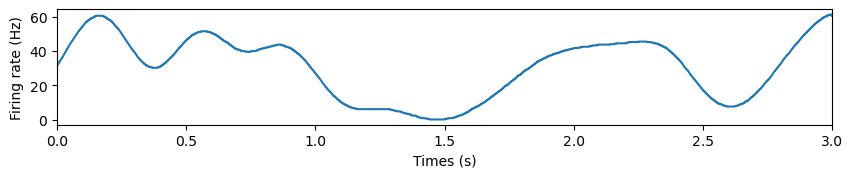

In [5]:
plt.figure(figsize=(10,1.5))
plt.plot(times,firing_rates)
plt.xlim(0,3)
plt.xlabel('Times (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

## Single spike train

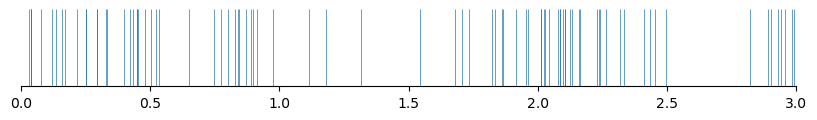

In [6]:
# generate a spike train and visualize
f,a = plt.subplots(figsize=(10,1))
for l in ['top','left','right']:
    a.spines[l].set_visible(False)
a.vlines(gen_spikes(firing_rates,delta_t),0,1,lw=.5)
a.set_yticks([])
a.set_xlim(0,3)
a.set_ylim(0,1)
plt.show()

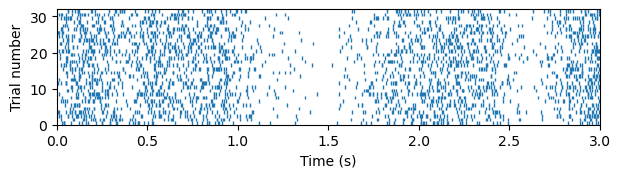

In [7]:
f,a = plt.subplots(figsize=(7,1.5))
num_trial = 32
for trial in range(num_trial):
    trial_spikes = gen_spikes(firing_rates,delta_t,seed=trial)
    a.vlines(trial_spikes,trial,trial+1,lw=1)
a.set_xlim(0,3.0)
a.set_ylim(0,num_trial)
a.set_xlabel('Time (s)')
a.set_ylabel('Trial number')
plt.show()

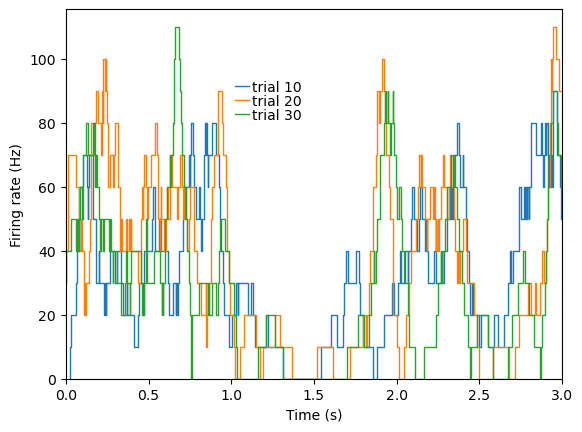

In [8]:
f,a = plt.subplots()
for trial in [10,20,30]:
    trial_win_times,train_win_rates = sliding_window(gen_spikes(firing_rates,delta_t,seed=trial),win_size=0.1)
    a.plot(trial_win_times,train_win_rates,label=f'trial {trial}',lw=1)
a.set_xlim(0,3)
a.set_ylim(0,None)
a.legend(frameon=False,labelspacing=0,loc=(0.33,0.68),handlelength=1,handletextpad=0.25)
a.set_xlabel('Time (s)')
a.set_ylabel('Firing rate (Hz)')
plt.show()

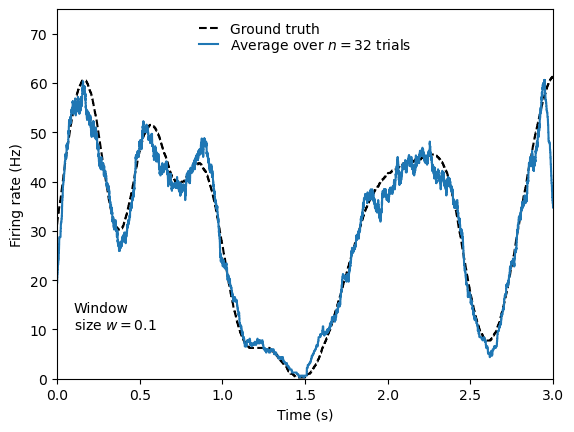

In [9]:
f = plt.figure()
win_size = 0.1
plt.plot(times,firing_rates,'--',color='k',label='Ground truth')
n_trial = 32
all_spike_times = np.concatenate([[
    gen_spikes(firing_rates,delta_t,seed=seed)][-1]
    for seed in range(n_trial)])
win_times,win_rates = sliding_window(sorted(all_spike_times),win_size)
win_rates /= n_trial # Average rate per trial
plt.plot(win_times,win_rates,label=f'Average over $n={n_trial}$ trials')
plt.xlim(0,3)
plt.ylim(0,75)
plt.text(0.1,10,f'Window\nsize $w={win_size}$')
plt.legend(frameon=False,loc='upper center',handlelength=1.4,labelspacing=0)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

## Bias–variance trade off

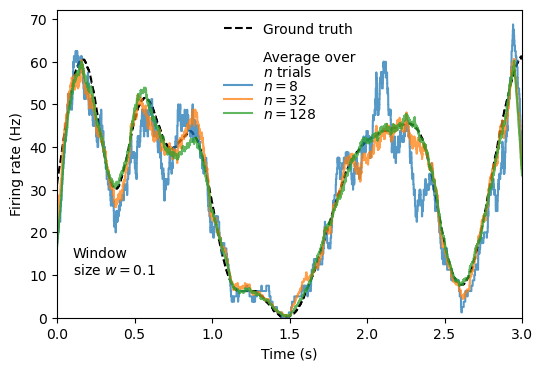

In [10]:
f = plt.figure(figsize=(6,4))
win_size = 0.1
plt.plot(times,firing_rates,'--',color='k',label='Ground truth')
plt.plot([],[],'',color='None',label=' ')
plt.plot([],[],'',color='None',label="Average over")
plt.plot([],[],'',color='None',label="$n$ trials")
for num_trial in [8,32,128]:
    all_trial_spikes = np.concatenate([[
        gen_spikes(firing_rates,delta_t,seed=seed)
    ][-1] for seed in range(num_trial)])
    win_times,win_rates = sliding_window(sorted(all_trial_spikes),win_size)
    win_rates /= num_trial
    plt.plot(win_times,win_rates,label=f'$n={num_trial}$',alpha=0.75)
plt.xlim(0,3)
plt.ylim(0,None)
plt.text(0.1,10,f'Window\nsize $w={win_size}$')
plt.legend(frameon=False,loc='upper center',labelspacing=0)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

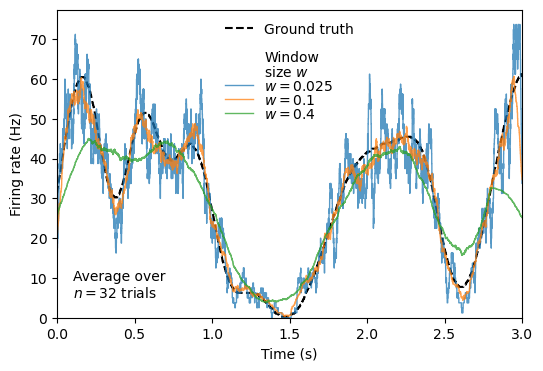

In [11]:
f = plt.figure(figsize=(6,4))
plt.plot(times,firing_rates,'--',color='k',label='Ground truth')
plt.plot([],[],'',color='None',label=' ')
plt.plot([],[],'',color='None',label="Window")
plt.plot([],[],'',color='None',label="size $w$")
num_trial = 32
for win_size in [0.025,0.1,0.4]:
    all_trial_spikes = np.concatenate([[
        gen_spikes(firing_rates,delta_t,seed=seed)
    ][-1] for seed in range(num_trial)])
    win_times,win_rates = sliding_window(sorted(all_trial_spikes),win_size)
    win_rates /= num_trial
    plt.plot(win_times,win_rates,label=fr'$w={win_size}$',alpha=0.75,lw=1)
plt.xlim(0,3)
plt.ylim(0,None)
plt.text(0.1,5,f'Average over\n$n={num_trial}$ trials')
plt.legend(frameon=False,loc='upper center',labelspacing=0)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.show()

## Generate Poisson spike train

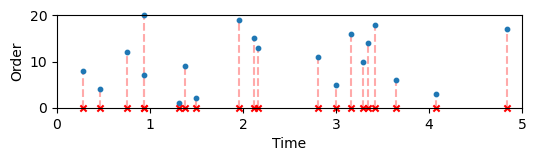

In [12]:
rate,xmax = 4,5.0
num_spikes = int(rate*xmax) # Using average
rng = np.random.default_rng(2)
f,a = plt.subplots(figsize=(6,1.2))
xs = rng.uniform(0,xmax,size=num_spikes)
ys = np.arange(len(xs))+1
a.scatter(xs,ys,marker='o',s=10,clip_on=False)
a.scatter(xs,np.zeros_like(xs),marker='x',s=20,color='r',clip_on=False)
a.vlines(xs,0,ys,color='#faa',linestyles='--',zorder=0)
a.set_xlim(0,xmax)
a.set_ylim(0,num_spikes)
a.set_xlabel('Time')
a.set_ylabel('Order')
plt.show()

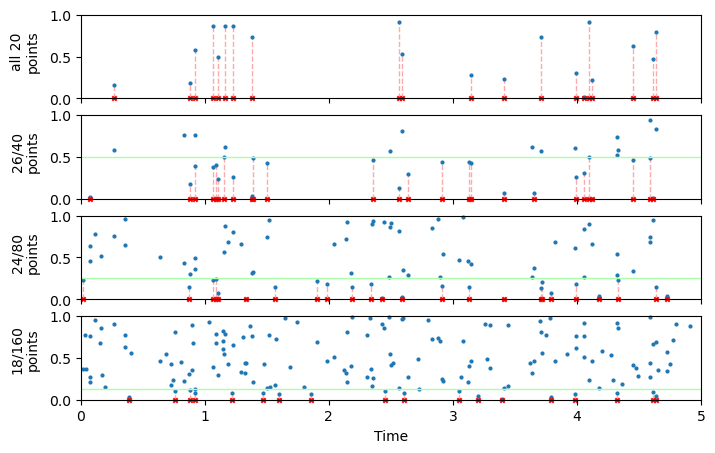

In [13]:
rate,xmax = 4,5.0
kept_fractions = [1,0.5,0.25,0.125]
f,aa = plt.subplots(len(kept_fractions),1,figsize=(8,5))
for kept,a in zip(kept_fractions,aa):
    num_spikes = int(rate*xmax/kept)
    rng = np.random.default_rng(123)
    xs = rng.uniform(0,xmax,size=num_spikes)
    ys = rng.uniform(0,1,size=num_spikes)
    a.scatter(xs,ys,marker='o',s=4,clip_on=False)
    xs_kept,ys_kept = xs[ys<kept],ys[ys<kept]
    a.scatter(xs_kept,np.zeros_like(xs_kept),marker='x',s=10,color='r',clip_on=False)
    a.vlines(xs_kept,0,ys_kept,color='#faa',linestyles='--',zorder=0,lw=1)
    if kept<1: a.axhline(kept,color='#afa',lw=1)
    a.set_xlim(0,xmax)
    a.set_ylim(0,1)
    a.text(-0.45,0.35,(
        f'all {num_spikes}' if kept==1 else f'{len(xs_kept)}/{num_spikes}'
    )+'\npoints',rotation='vertical',ha='center')
for a in aa[:-1]: a.set_xticklabels([])
aa[-1].set_xlabel('Time')
plt.show()

## Poisson spike train with time-varying rate

In [14]:
# Some time-varying rate
time_range = 5
delta_t = 1/128
times = np.arange(0,time_range,delta_t)
rates = 10*np.sin(times*(2+times/10))**2+times*(5-times)/10

In [15]:
rate_max = np.max(rates)    # Maximum rate
num_points = round(rate_max*time_range) # Points to generate

In [16]:
rng = np.random.default_rng(13)
xs = rng.uniform(0,time_range,size=num_points)
ys = rng.uniform(0,rate_max,size=num_points)

In [17]:
# Pick points below the rate curve
kept_indices = ys<np.take(rates,np.floor(xs/delta_t).astype(int))
xs_kept = xs[kept_indices]
ys_kept = ys[kept_indices]

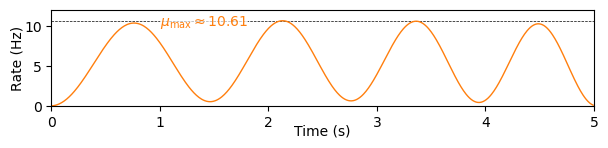

In [18]:
plt.figure(figsize=(7,1.25))
plt.axhline(rate_max,color='k',ls='--',lw=0.5)
plt.plot(times,rates,color='C1',lw=1)
plt.xlim(0,5)
plt.ylim(0,12)
plt.yticks([0,5,10])
plt.xlabel('Time (s)',labelpad=-4)
plt.ylabel('Rate (Hz)',labelpad=0)

plt.text(1,10,fr'$\mu_\max \approx {rate_max:5.4g}$',color='C1',bbox={'linestyle':'None','pad':0,'facecolor':'#fffa'})
plt.show()

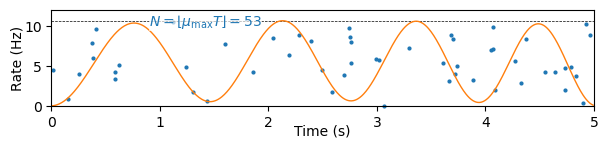

In [19]:
plt.figure(figsize=(7,1.25))
plt.axhline(rate_max,color='k',ls='--',lw=0.5)
plt.plot(times,rates,color='C1',lw=1)
plt.xlim(0,5)
plt.ylim(0,12)
plt.yticks([0,5,10])
plt.xlabel('Time (s)',labelpad=-4)
plt.ylabel('Rate (Hz)',labelpad=0)

plt.scatter(xs,ys,s=4,clip_on=False)
plt.text(0.9,10,fr'$N=\lfloor\mu_\max T\rfloor={num_points}$',color='C0',bbox={'linestyle':'None','pad':0,'facecolor':'#fffa'})
plt.show()

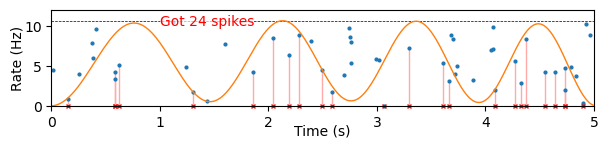

In [20]:
plt.figure(figsize=(7,1.25))
plt.axhline(rate_max,color='k',ls='--',lw=0.5)
plt.plot(times,rates,color='C1',lw=1)
plt.xlim(0,5)
plt.ylim(0,12)
plt.yticks([0,5,10])
plt.xlabel('Time (s)',labelpad=-4)
plt.ylabel('Rate (Hz)',labelpad=0)

plt.scatter(xs,ys,s=4,clip_on=False)
plt.scatter(xs_kept,np.zeros_like(xs_kept),marker='x',color='r',clip_on=False,lw=1,s=8)
plt.vlines(xs_kept,0,ys_kept,color='#faa',zorder=0,lw=1)
plt.text(1,10,fr'Got {len(xs_kept)} spikes',color='r',bbox={'linestyle':'None','pad':0,'facecolor':'#fffa'})
plt.show()

In [21]:
# Make up a time-varying spike rate
time_range = 5  # Total range of time
delta_t = 1/100 # Time step size

times = np.arange(0,time_range,delta_t) # Time points
rates = 10*np.sin(times*(2+times/10))**2+times*(5-times)/10 # Rates

# Create box and find the number of points needed in the box
rate_max = np.max(rates)
num_points = round(rate_max*time_range) # Total number of points

# Generate random points in the box
rng = np.random.default_rng(12)
xs = rng.uniform(0,time_range,size=num_points)
ys = rng.uniform(0,rate_max,size=num_points)

# Pick points under the rate curve
kept_indices = ys<np.take(rates,np.floor(xs/delta_t).astype(int))
xs_kept,ys_kept = xs[kept_indices],ys[kept_indices]

final_spikes = np.sort(xs_kept) # Resulting sorted spike train

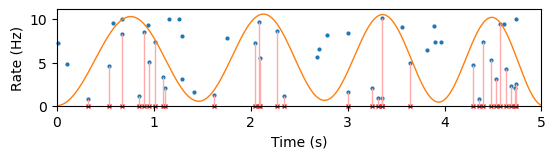

In [22]:
plt.figure(figsize=(6.25,1.25))
plt.plot(times,rates,color='C1',lw=1)
plt.scatter(xs,ys,s=4,clip_on=False)
plt.scatter(xs_kept,np.zeros_like(xs_kept),s=8,
  marker='x',color='r',clip_on=False,lw=1)
plt.vlines(xs_kept,0,ys_kept,color='#faa',lw=1)
plt.xlim(0,5)
plt.ylim(0,None)
plt.yticks([0,5,10])
plt.xlabel('Time (s)')
plt.ylabel('Rate (Hz)')
plt.show()

# Random number generator

## Problem with linear congruential generators

In [23]:
# The rand() function of ANSI C
m,a,c,x0 = 2**31,1103515245,12345,12345 # Parameters
x = x0
seq = [(x:=(a*x+c)%m) for i in range(2**26)]    

In [24]:
s,k = 2,25 # k=25 step test in s=2 dimension
xx = np.array([seq[k*i:(i-s)*k] for i in range(s)])
xx = (xx-min(seq))/(max(seq)-min(seq)) # normalize

In [25]:
xx.shape

(2, 67108814)

In [26]:
xx[:,:30].T

array([[0.65515405, 0.44545755],
       [0.30481432, 0.70840156],
       [0.67496064, 0.73989464],
       [0.10676848, 0.17277819],
       [0.51657445, 0.01570539],
       [0.48966634, 0.78257732],
       [0.6024722 , 0.04120625],
       [0.36995476, 0.5974326 ],
       [0.25666706, 0.24569723],
       [0.3741822 , 0.5564614 ],
       [0.82558498, 0.51521919],
       [0.17271991, 0.39745044],
       [0.29781185, 0.18261657],
       [0.64353066, 0.64595717],
       [0.78965488, 0.71654419],
       [0.98781129, 0.30494221],
       [0.80057087, 0.97147867],
       [0.4642571 , 0.8345324 ],
       [0.53899865, 0.39009196],
       [0.62549298, 0.70487336],
       [0.24999192, 0.12551621],
       [0.70388805, 0.60776515],
       [0.7162836 , 0.54907614],
       [0.97951757, 0.69988353],
       [0.32902169, 0.90398702],
       [0.44545755, 0.39687404],
       [0.70840156, 0.8323131 ],
       [0.73989464, 0.61846538],
       [0.17277819, 0.01615343],
       [0.01570539, 0.37498291]])

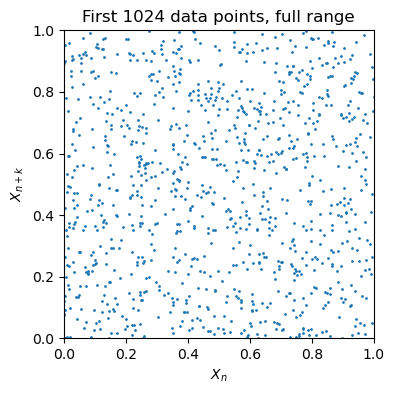

In [27]:
plt.figure(figsize=(4,4))
plt.plot(*xx[:,:1024],'o',ms=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('$X_n$')
plt.ylabel('$X_{n+k}$')
plt.title('First 1024 data points, full range')
plt.show()

In [28]:
# Zoom-in range
ii = (xx[0]>0.1)*(xx[0]<0.105)*(xx[1]>0.1)*(xx[1]<0.105)

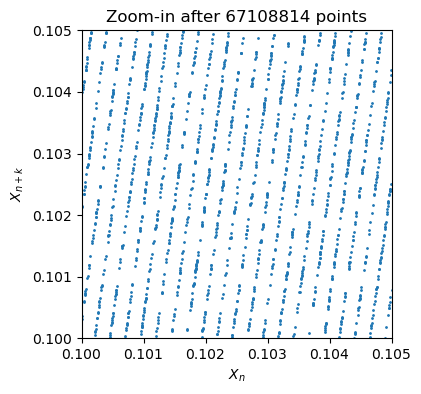

In [29]:
plt.figure(figsize=(4,4))
plt.plot(*xx[:,ii],'.',ms=2)
plt.xlim(0.1,0.105)
plt.ylim(0.1,0.105)
plt.xlabel('$X_n$')
plt.ylabel('$X_{n+k}$')
plt.title(f'Zoom-in after {xx.shape[1]} points')
plt.show()

# Homework rate data

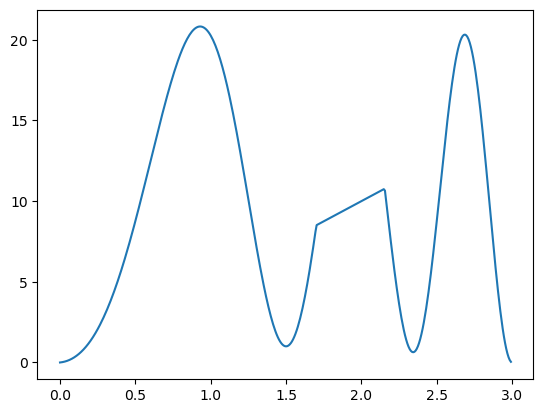

In [30]:
duration = 3
delta_t = 2**-7
times = np.arange(0,duration,delta_t)
rates = 20*np.sin(np.pi*(times**2*2/9+times/3))**2+np.sin(np.pi*times/3)
ii = (times>1.5)*(times<2.4)*(rates>times*5)
rates[ii] = times[ii]*5
plt.plot(times,rates)
plt.show()

In [31]:
np.savez('hw03-data.npz',rates=rates,delta_t=delta_t)

In [32]:
with np.load('hw03-data.npz',allow_pickle=True) as f:
    rates = f['rates']
    delta_t = f['delta_t'][()]

<hr>
<address style="color:#44f;font-style:italic;font-weight:bold;"><a href="https://cc.tir.tw/wk/2025cns">CNS2025</a></address>